In [38]:
import numpy as np
import numba
from numba import jit,cuda
import time
import pandas as pd
import matplotlib.pyplot as plt
import cpuinfo
import multiprocessing

In [39]:
proc_name = cpuinfo.get_cpu_info()['brand_raw']
cores_count = multiprocessing.cpu_count()
print(f'Процессор: {proc_name}')
print(f'Количество ядер: {cores_count}')
print('GPU:')
!nvidia-smi

Процессор: Intel(R) Xeon(R) CPU @ 2.20GHz
Количество ядер: 2
GPU:
Fri Nov 17 10:53:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    235MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                      

In [40]:
@cuda.jit
def gpu_matmul(matrix_a, matrix_b, result_matrix):
    i,j = cuda.grid(2) # индекс потока
    if i < result_matrix.shape[0] and j < result_matrix.shape[1]:
        for idx in range(result_matrix.shape[1]):
            result_matrix[i,j] += matrix_a[i,idx] * matrix_b[idx,j]

In [41]:
def numpy_cpu_matmul(matrix_a,matrix_b):
    return matrix_a.dot(matrix_b)

In [42]:
blocks_per_grid = (256,256)#размер сетки
threads_per_block = (32,32)#потоков в блоке

iters = 10 # кол-вол экспериментов для каждого размера
num_diff_size = 20 # кол-во размеров матриц

cpu_times = np.zeros(num_diff_size)
gpu_times = np.zeros(num_diff_size)
matrix_size = np.linspace(100,2000,num_diff_size,dtype=np.int32)

In [43]:
%%time
for iter, size in enumerate(matrix_size):
    print(f'calc matrix with size {size,size}')
    cpu_times_per_size = np.zeros(iters)

    gpu_times_per_size = np.zeros(iters)

    matrix_a = np.random.randn(size,size)
    matrix_b = np.random.randn(size,size)
    matrix_result = np.zeros((size,size))

    matrix_a_gpu = cuda.to_device(matrix_a)
    matrix_b_gpu = cuda.to_device(matrix_b)

    for i in range(iters):
        matrix_result_gpu = cuda.to_device(matrix_result)

        cpu_start = time.time()
        cpu_result = numpy_cpu_matmul(matrix_a,matrix_b)
        cpu_times_per_size[i] = time.time() - cpu_start

        gpu_start = time.time()
        gpu_matmul[blocks_per_grid,threads_per_block](matrix_a_gpu,matrix_b_gpu, matrix_result_gpu)
        gpu_times_per_size[i] = time.time() - gpu_start

        gpu_matrix_result = matrix_result_gpu.copy_to_host()

    if np.allclose(gpu_matrix_result,cpu_result):
        print(f'Результат умножения матриц размером {size,size} на cpu и gpu равны')
    else:
        print(f'Результат умножения матриц размером {size,size} на cpu и gpu не равны')

    cpu_times[iter] = np.mean(cpu_times_per_size)
    gpu_times[iter] = np.mean(gpu_times_per_size)

calc matrix with size (100, 100)
Результат умножения матриц размером (100, 100) на cpu и gpu равны
calc matrix with size (200, 200)
Результат умножения матриц размером (200, 200) на cpu и gpu равны
calc matrix with size (300, 300)
Результат умножения матриц размером (300, 300) на cpu и gpu равны
calc matrix with size (400, 400)
Результат умножения матриц размером (400, 400) на cpu и gpu равны
calc matrix with size (500, 500)
Результат умножения матриц размером (500, 500) на cpu и gpu равны
calc matrix with size (600, 600)
Результат умножения матриц размером (600, 600) на cpu и gpu равны
calc matrix with size (700, 700)
Результат умножения матриц размером (700, 700) на cpu и gpu равны
calc matrix with size (800, 800)
Результат умножения матриц размером (800, 800) на cpu и gpu равны
calc matrix with size (900, 900)
Результат умножения матриц размером (900, 900) на cpu и gpu равны
calc matrix with size (1000, 1000)
Результат умножения матриц размером (1000, 1000) на cpu и gpu равны
calc m

In [44]:
data = pd.DataFrame(columns=['avg cpu times','avg gpu times','boost'],index=matrix_size)
data['avg cpu times']=cpu_times
data['avg gpu times'] = gpu_times
data['boost'] = cpu_times/gpu_times
data.to_csv('data.csv',sep='\t')
data

,avg cpu times,avg gpu times,boost
100,0.002291,0.026773,0.085572
200,0.003998,0.000206,19.388253
300,0.004365,0.000216,20.181548
400,0.008394,0.000216,38.848064
500,0.017143,0.000279,61.349147
600,0.025432,0.000305,83.258508
700,0.038286,0.000328,116.670009
800,0.059026,0.000415,142.192867
900,0.041990,0.000381,110.261504
1000,0.055586,0.000370,150.416065


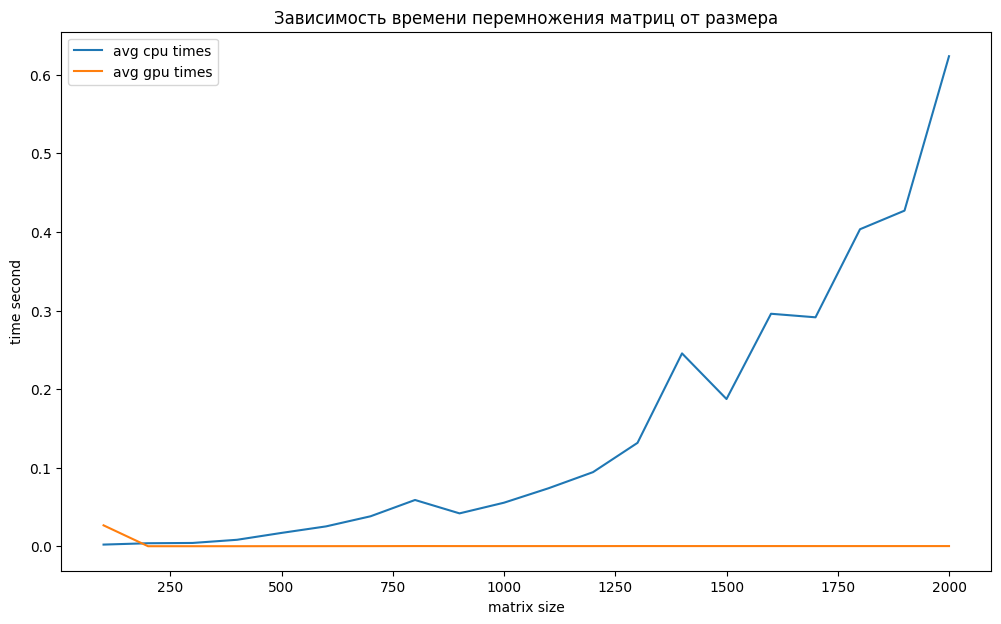

In [45]:
plt.figure(figsize=(12,7))
plt.plot(matrix_size, cpu_times,label='avg cpu times')
plt.plot(matrix_size, gpu_times, label = 'avg gpu times')
plt.xlabel('matrix size')
plt.ylabel('time second')
plt.title('Зависимость времени перемножения матриц от размера')
plt.legend()
plt.savefig('cpu and gpu times.png',dpi=800)

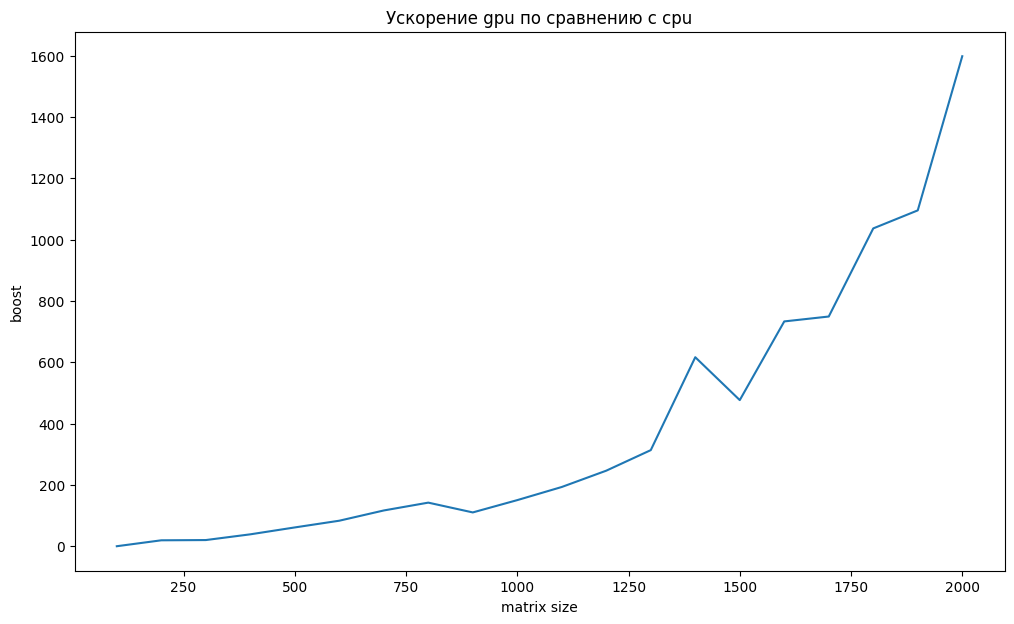

In [46]:
plt.figure(figsize=(12,7))
plt.plot(matrix_size, cpu_times/gpu_times)
plt.xlabel('matrix size')
plt.ylabel('boost')
plt.title('Ускорение gpu по сравнению с cpu')
plt.savefig('gpu cpu boost.png',dpi=800)